In [1]:
%matplotlib inline
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.tensorboard.plugins import projector
import os
from scipy import spatial
from collections import defaultdict
tf.logging.set_verbosity(tf.logging.ERROR)
import datetime
import timeit 
from tqdm import tqdm_notebook
import scipy.stats

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [3]:
# evluated word2vec model results
path_results     = './results'
name_Slex        = 'w2v_scoring_Slex.csv'
name_Wsim        = 'w2v_scoring_Wsim.csv'
name_Mens        = 'w2v_scoring_Mens.csv'
name_Spmr        = 'w2v_scoring_Spmr.csv'

In [4]:
#os.chdir('..')
#!pwd
sent_Slex1= pd.read_csv('./sentence_generator/output.txt', sep = ',', names = ['pair', 'word', 'sentence'])
sent_Slex2= pd.read_csv('./sentence_generator/output_2.txt', sep = ',', names = ['pair', 'word', 'sentence'])
# sent_Slex1= pd.read_csv('./sentence_generator_30/simlex999_30_1.txt', sep = ',', names = ['pair', 'word', 'sentence'])
# sent_Slex2= pd.read_csv('./sentence_generator_30/simlex999_30_2.txt', sep = ',', names = ['pair', 'word', 'sentence'])

sent_Wsim1= pd.read_csv('./sentence_generator/wordSim_1.txt', sep = ',', names = ['pair', 'word', 'sentence'])
sent_Wsim2= pd.read_csv('./sentence_generator/wordSim_2.txt', sep = ',', names = ['pair', 'word', 'sentence'])

sent_Mens1= pd.read_csv('./sentence_generator/MEN_1.txt', sep = ',', names = ['pair', 'word', 'sentence'])
sent_Mens2= pd.read_csv('./sentence_generator/MEN_2.txt', sep = ',', names = ['pair', 'word', 'sentence'])

In [5]:
#%%prun -s cumulative -s line
# one time initialization

distances_Slex = {}
distances_Wsim = {}
distances_Mens = {}

range_Slex = range(1, len(np.unique(sent_Slex1.pair))+1)
range_Wsim = range(1, len(np.unique(sent_Wsim1.pair))+1)
range_Mens = range(1, len(np.unique(sent_Mens1.pair))+1)

tf_x = tf.placeholder(tf.string)
tf_y = tf.placeholder(tf.string)

# return elmo embeddings for the input sentence/context
def elmo_embed(inp_arr):
    return elmo(inp_arr, signature="default", as_dict=True)["elmo"] 

elmo_x = elmo_embed(tf_x)
elmo_y = elmo_embed(tf_y)

init = tf.initialize_all_variables()

In [6]:
print("Evaluating SimLex...", end='')
with tf.Session() as sess:
    for i in tqdm_notebook(range_Slex):
        pair_no = i
        
        sents_1= np.asarray(sent_Slex1.loc[sent_Slex1['pair'] == i].sentence)
        word_1 = np.unique(sent_Slex1.loc()[sent_Slex1['pair'] == i].word)[0]
        word_1_indices = []
        for sent in sents_1:
            x = sent.split()
            word_1_indices.append(x.index(word_1))
    
        sents_2 = np.asarray(sent_Slex2.loc[sent_Slex2['pair'] == i].sentence)
        word_2 = np.unique(sent_Slex2.loc()[sent_Slex2['pair'] == i].word)[0]
        word_2_indices = []
        for sent in sents_2:
            x = sent.split()
            word_2_indices.append(x.index(word_2))
    
        sess.run(init)
        embed_1, embed_2 = sess.run([elmo_x, elmo_y], feed_dict={tf_x: sents_1, tf_y: sents_2})
        
        target_embeddings_1 = []
        for j in range(len(embed_1)):
            target_embeddings_1.append(embed_1[j][word_1_indices[j]])
            mean_embedding_1 = np.mean(np.asarray(target_embeddings_1), axis = 0)
    
        target_embeddings_2 = []
        for j in range(len(embed_2)):
            target_embeddings_2.append(embed_2[j][word_2_indices[j]])
            mean_embedding_2 = np.mean(np.asarray(target_embeddings_2), axis = 0)
    
        distance = 1 - spatial.distance.cosine(mean_embedding_1, mean_embedding_2)
        distances_Slex[(word_1, word_2)] = distance
print("finished.")

Evaluating SimLex...

HBox(children=(IntProgress(value=0, max=999), HTML(value='')))


finished.


In [7]:
print("Evaluating WordSim...", end='')
with tf.Session() as sess:
    for i in tqdm_notebook(range_Wsim):
        pair_no = i
        
        sents_1= np.asarray(sent_Wsim1.loc[sent_Wsim1['pair'] == i].sentence)
        word_1 = np.unique(sent_Wsim1.loc()[sent_Wsim1['pair'] == i].word)[0]
        word_1_indices = []
        for sent in sents_1:
            x = sent.split()
            word_1_indices.append(x.index(word_1))
    
        sents_2 = np.asarray(sent_Wsim2.loc[sent_Wsim2['pair'] == i].sentence)
        word_2 = np.unique(sent_Wsim2.loc()[sent_Wsim2['pair'] == i].word)[0]
        word_2_indices = []
        for sent in sents_2:
            x = sent.split()
            word_2_indices.append(x.index(word_2))
    
        sess.run(init)
        embed_1, embed_2 = sess.run([elmo_x, elmo_y], feed_dict={tf_x: sents_1, tf_y: sents_2})
        
        target_embeddings_1 = []
        for j in range(len(embed_1)):
            target_embeddings_1.append(embed_1[j][word_1_indices[j]])
            mean_embedding_1 = np.mean(np.asarray(target_embeddings_1), axis = 0)
    
        target_embeddings_2 = []
        for j in range(len(embed_2)):
            target_embeddings_2.append(embed_2[j][word_2_indices[j]])
            mean_embedding_2 = np.mean(np.asarray(target_embeddings_2), axis = 0)
    
        distance = 1 - spatial.distance.cosine(mean_embedding_1, mean_embedding_2)
        distances_Wsim[(word_1, word_2)] = distance
print("finished.")

Evaluating WordSim...

HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


finished.


In [8]:
print("Evaluating MEN...", end='')
with tf.Session() as sess:
    for i in tqdm_notebook(range_Mens):
        pair_no = i
        
        sents_1= np.asarray(sent_Mens1.loc[sent_Mens1['pair'] == i].sentence)
        word_1 = np.unique(sent_Mens1.loc()[sent_Mens1['pair'] == i].word)[0]
        word_1_indices = []
        for sent in sents_1:
            x = sent.split()
            word_1_indices.append(x.index(word_1))
    
        sents_2 = np.asarray(sent_Mens2.loc[sent_Mens2['pair'] == i].sentence)
        word_2 = np.unique(sent_Mens2.loc()[sent_Mens2['pair'] == i].word)[0]
        word_2_indices = []
        for sent in sents_2:
            x = sent.split()
            word_2_indices.append(x.index(word_2))
    
        sess.run(init)
        embed_1, embed_2 = sess.run([elmo_x, elmo_y], feed_dict={tf_x: sents_1, tf_y: sents_2})
        
        target_embeddings_1 = []
        for j in range(len(embed_1)):
            target_embeddings_1.append(embed_1[j][word_1_indices[j]])
            mean_embedding_1 = np.mean(np.asarray(target_embeddings_1), axis = 0)
    
        target_embeddings_2 = []
        for j in range(len(embed_2)):
            target_embeddings_2.append(embed_2[j][word_2_indices[j]])
            mean_embedding_2 = np.mean(np.asarray(target_embeddings_2), axis = 0)
    
        distance = 1 - spatial.distance.cosine(mean_embedding_1, mean_embedding_2)
        distances_Mens[(word_1, word_2)] = distance
print("finished.")

Evaluating MEN...

HBox(children=(IntProgress(value=0, max=3000), HTML(value='')))


finished.


In [9]:
# display a few scored word pairs
for i, wpair in zip(range(0,4), distances_Slex):
    print("{:30s} : {:6.4f}".format(str(wpair), distances_Slex[wpair]))

('childish', 'foolish')        : 0.7495
('child', 'boy')               : 0.7489
('child', 'adult')             : 0.4919
('author', 'creator')          : 0.6580


### Evaluation:



In [10]:
# load evaluation datsets
path_evalsetSlex = '..\\datasets\\SimLex-999\\SimLex-999.txt'
path_evalsetWsim = '..\\datasets\\WordSim-353\\combined.csv'
path_evalsetMens = '..\\datasets\\MEN\\MEN_dataset_natural_form_full'

evalsetSlex = pd.read_csv(path_evalsetSlex, sep='\t')
evalsetWsim = pd.read_csv(path_evalsetWsim, sep=',')
evalsetMens = pd.read_csv(path_evalsetMens, sep=' ', header=None)
evalsetMens.columns = ['word1', 'word2', 'MEN_score']

print("\nSimLex eval set:")
display(evalsetSlex.head())
print("\nWordSim eval set:")
display(evalsetWsim.head())
print("\nMEN eval set:")
display(evalsetMens.head())

evalset_name_list = ['SimLex-999', 'WordSim-353', 'MEN (3000)']


SimLex eval set:


,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93



WordSim eval set:


,Word 1,Word 2,Human (mean)
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62



MEN eval set:


,word1,word2,MEN_score
0,sun,sunlight,50.0
1,automobile,car,50.0
2,river,water,49.0
3,stairs,staircase,49.0
4,morning,sunrise,49.0


In [11]:
# ranking the scores

Slex_sorted = evalsetSlex.copy()
print("\nSimLex-999 eval dataset sample:")
display(Slex_sorted.head())
Slex_sorted = Slex_sorted.filter(items=['word1', 'word2', 'SimLex999', 'SD(SimLex)'], axis=1)
Slex_sorted = Slex_sorted.sort_values(by=['SimLex999'], ascending=False)
Slex_sorted = Slex_sorted.set_index(pd.Index(range(0,Slex_sorted.shape[0])))

Wsim_sorted = evalsetWsim.copy()
print("\nWordSim-353 eval dataset sample:")
display(Wsim_sorted.head())
Wsim_sorted = Wsim_sorted.sort_values(by=['Human (mean)'], ascending=False)
Wsim_sorted = Wsim_sorted.set_index(pd.Index(range(0,Wsim_sorted.shape[0])))

Mens_sorted = evalsetMens.copy()
print("\nMEN (3000) eval dataset sample:")
display(Mens_sorted.head())
Mens_sorted = Mens_sorted.sort_values(by=['MEN_score'], ascending=False)
Mens_sorted = Mens_sorted.set_index(pd.Index(range(0,Mens_sorted.shape[0])))

# add the rank column
print('*'*80)
rank = 0
Slex_sorted['rank_simlex'] = Slex_sorted.index + 1
print("\nTop and bottom rows of ranked SimLex eval dataset:")
display(pd.concat([Slex_sorted.head(), Slex_sorted.tail()], axis=0))

rank = 0
Wsim_sorted['rank_wordsim'] = Wsim_sorted.index + 1
print("\nTop and bottom rows of ranked WordSim eval dataset:")
display(pd.concat([Wsim_sorted.head(), Wsim_sorted.tail()], axis=0))

rank = 0
Mens_sorted['rank_men'] = Mens_sorted.index + 1
print("\nTop and bottom rows of ranked MEN eval dataset:")
display(pd.concat([Mens_sorted.head(), Mens_sorted.tail()], axis=0))


SimLex-999 eval dataset sample:


,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93



WordSim-353 eval dataset sample:


,Word 1,Word 2,Human (mean)
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62



MEN (3000) eval dataset sample:


,word1,word2,MEN_score
0,sun,sunlight,50.0
1,automobile,car,50.0
2,river,water,49.0
3,stairs,staircase,49.0
4,morning,sunrise,49.0


********************************************************************************

Top and bottom rows of ranked SimLex eval dataset:


,word1,word2,SimLex999,SD(SimLex),rank_simlex
0,vanish,disappear,9.80,0.46,1
1,quick,rapid,9.70,1.14,2
2,creator,maker,9.62,1.40,3
3,stupid,dumb,9.58,1.48,4
4,insane,crazy,9.57,0.92,5
994,gun,fur,0.30,1.80,995
995,chapter,tail,0.30,1.57,996
996,dirty,narrow,0.30,0.89,997
997,new,ancient,0.23,0.46,998
998,shrink,grow,0.23,1.20,999



Top and bottom rows of ranked WordSim eval dataset:


,Word 1,Word 2,Human (mean),rank_wordsim
0,tiger,tiger,10.00,1
1,fuck,sex,9.44,2
2,journey,voyage,9.29,3
3,midday,noon,9.29,4
4,dollar,buck,9.22,5
348,rooster,voyage,0.62,349
349,noon,string,0.54,350
350,chord,smile,0.54,351
351,professor,cucumber,0.31,352
352,king,cabbage,0.23,353



Top and bottom rows of ranked MEN eval dataset:


,word1,word2,MEN_score,rank_men
0,sun,sunlight,50.0,1
1,automobile,car,50.0,2
2,river,water,49.0,3
3,stairs,staircase,49.0,4
4,morning,sunrise,49.0,5
2995,feathers,truck,1.0,2996
2996,festival,whiskers,1.0,2997
2997,muscle,tulip,1.0,2998
2998,bikini,pizza,1.0,2999
2999,bakery,zebra,0.0,3000


In [13]:
# Evaluating model's scoring on eval dataset(s)

# Simlex
elmo_Slex = Slex_sorted.copy()
elmo_Slex['elmo_score'] = Slex_sorted.apply(lambda row: distances_Slex[(row['word1'], row['word2'])], axis=1 )
elmo_Slex_sorted = elmo_Slex.sort_values(by=['elmo_score'], ascending=False)
elmo_Slex_sorted = elmo_Slex_sorted.set_index(pd.Index(range(0,elmo_Slex_sorted.shape[0])))
elmo_Slex_sorted['rank_elmo'] = elmo_Slex_sorted.index + 1
elmo_Slex_sorted = elmo_Slex_sorted.sort_values(by=['SimLex999'], ascending=False)
elmo_Slex['rank_elmo'] = elmo_Slex_sorted['rank_elmo'].values
display(elmo_Slex[:10])

# Wordsim
elmo_Wsim = Wsim_sorted.copy()
elmo_Wsim['elmo_score'] = Wsim_sorted.apply(lambda row: distances_Wsim[(row['Word 1'].lower(), row['Word 2'].lower())], axis=1 )
elmo_Wsim_sorted = elmo_Wsim.sort_values(by=['elmo_score'], ascending=False)
elmo_Wsim_sorted = elmo_Wsim_sorted.set_index(pd.Index(range(0,elmo_Wsim_sorted.shape[0])))
elmo_Wsim_sorted['rank_elmo'] = elmo_Wsim_sorted.index + 1
elmo_Wsim_sorted = elmo_Wsim_sorted.sort_values(by=['Human (mean)'], ascending=False)
elmo_Wsim['rank_elmo'] = elmo_Wsim_sorted['rank_elmo'].values
display(elmo_Wsim[:10])
# 
# # MEN
elmo_Mens = Mens_sorted.copy()
elmo_Mens['elmo_score'] = Mens_sorted.apply(lambda row: distances_Mens[(row['word1'], row['word2'])], axis=1 )
elmo_Mens_sorted = elmo_Mens.sort_values(by=['elmo_score'], ascending=False)
elmo_Mens_sorted = elmo_Mens_sorted.set_index(pd.Index(range(0,elmo_Mens_sorted.shape[0])))
elmo_Mens_sorted['rank_elmo'] = elmo_Mens_sorted.index + 1
elmo_Mens_sorted = elmo_Mens_sorted.sort_values(by=['MEN_score'], ascending=False)
elmo_Mens['rank_elmo'] = elmo_Mens_sorted['rank_elmo'].values
display(elmo_Mens[:10])

### DUMP ALL THREE TO CSVs
print("\nEval datasets as ranked by ELMo:")
#elmo_Slex.to_csv('elmo_scoring_simlex.csv')
#display(pd.concat([elmo_Slex.head(10), elmo_Slex.tail(10)], axis=0))
# display(elmo_Wsim.head())
# display(elmo_Mens.head())
elmo_Mens.to_csv('elmo_scoring_mens.csv')

elmo_spearman = list()
elmo_spearman.append(scipy.stats.spearmanr(elmo_Slex['rank_simlex'], elmo_Slex['rank_elmo'])[0])
elmo_spearman.append(scipy.stats.spearmanr(elmo_Wsim['rank_wordsim'], elmo_Wsim['rank_elmo'])[0])
elmo_spearman.append(scipy.stats.spearmanr(elmo_Mens['rank_men'], elmo_Mens['rank_elmo'])[0])

print('*'*70)
elmo_spearman_df = pd.DataFrame({'Dataset': evalset_name_list, 'Spearman rank coeff.': elmo_spearman})
display(elmo_spearman_df)

,word1,word2,SimLex999,SD(SimLex),rank_simlex,elmo_score,rank_elmo
0,vanish,disappear,9.80,0.46,1,0.877750,3
1,quick,rapid,9.70,1.14,2,0.580967,333
2,creator,maker,9.62,1.40,3,0.618955,245
3,stupid,dumb,9.58,1.48,4,0.747013,46
4,insane,crazy,9.57,0.92,5,0.693877,109
5,large,big,9.55,0.44,6,0.696667,262
6,happy,cheerful,9.55,2.18,7,0.610418,105
7,cow,cattle,9.52,0.79,8,0.629496,223
8,area,region,9.47,0.58,9,0.769555,34
9,large,huge,9.47,1.27,10,0.770860,33


,Word 1,Word 2,Human (mean),rank_wordsim,elmo_score,rank_elmo
0,tiger,tiger,10.00,1,1.000000,1
1,fuck,sex,9.44,2,0.161694,351
2,journey,voyage,9.29,3,0.761676,9
3,midday,noon,9.29,4,0.746435,11
4,dollar,buck,9.22,5,0.483690,100
5,money,cash,9.15,6,0.683880,24
6,coast,shore,9.10,7,0.606709,46
7,money,cash,9.08,8,0.683880,25
8,money,currency,9.04,9,0.420726,167
9,football,soccer,9.03,10,0.789497,5


,word1,word2,MEN_score,rank_men,elmo_score,rank_elmo
0,sun,sunlight,50.0,1,0.682909,138
1,automobile,car,50.0,2,0.725228,77
2,river,water,49.0,3,0.529010,880
3,stairs,staircase,49.0,4,0.704858,104
4,morning,sunrise,49.0,5,0.562937,324
5,rain,storm,49.0,6,0.521688,729
6,cat,kittens,49.0,7,0.618345,544
7,dance,dancers,49.0,8,0.562399,690
8,camera,photography,49.0,9,0.493885,538
9,bakery,bread,48.0,10,0.529728,684



Eval datasets as ranked by ELMo:
**********************************************************************


,Dataset,Spearman rank coeff.
0,SimLex-999,0.433909
1,WordSim-353,0.570375
2,MEN (3000),0.642624


### Performance comparison with Word2Vec

Here we inspect the word pairs that show contrasting rankings by word2vec against their Simlex ranking, and evaluate how these were ranked by the ELMo model.

In [14]:
w2v_Spmr = pd.read_csv(path_results + '/' + name_Spmr, index_col=0)
comb_Spmr = w2v_Spmr.copy()
comb_Spmr.columns = ['Dataset', 'Word2Vec']
comb_Spmr['ELMo'] = elmo_spearman_df['Spearman rank coeff.']
display(comb_Spmr)

,Dataset,Word2Vec,ELMo
0,SimLex-999,0.367297,0.433909
1,WordSim-353,0.591474,0.570375
2,MEN (3000),0.676167,0.642624


In [15]:
w2v_Slex = pd.read_csv(path_results + '/' + name_Slex, index_col=0)
w2v_Slex.head()

,word1,word2,SimLex999,SD(SimLex),rank_simlex,w2v_score,rank_w2v
0,vanish,disappear,9.80,0.46,1,0.910748,4
1,quick,rapid,9.70,1.14,2,0.414103,555
2,creator,maker,9.62,1.40,3,0.307668,758
3,stupid,dumb,9.58,1.48,4,0.804416,20
4,insane,crazy,9.57,0.92,5,0.616115,187


In [16]:
w2v_Slex['rank_delta_Slex_w2v'] = w2v_Slex.apply(lambda row: np.absolute(row['rank_simlex'] - row['rank_w2v']), axis=1)
#w2v_Slex_sorted = w2v_Slex.sort_values(by='rank_delta_Slex_w2v', ascending=False)
#print('\nOrdering word pairs by largest rank difference between eval datset and the model:')
#w2v_Slex_sorted = w2v_Slex_sorted.set_index(pd.Index(range(0,w2v_Slex_sorted.shape[0])))
#w2v_Slex_sorted.head()
w2v_Slex_sorted = w2v_Slex.copy()

In [17]:
w2v_Slex_sorted['rank_elmo'] = w2v_Slex_sorted.apply(
    lambda row: elmo_Slex[ (elmo_Slex['word1']==row['word1']) & (elmo_Slex['word2']==row['word2']) ]
    ['rank_elmo'].values[0], axis=1)
display(w2v_Slex_sorted.head())

,word1,word2,SimLex999,SD(SimLex),rank_simlex,w2v_score,rank_w2v,rank_delta_Slex_w2v,rank_elmo
0,vanish,disappear,9.80,0.46,1,0.910748,4,3,3
1,quick,rapid,9.70,1.14,2,0.414103,555,553,333
2,creator,maker,9.62,1.40,3,0.307668,758,755,245
3,stupid,dumb,9.58,1.48,4,0.804416,20,16,46
4,insane,crazy,9.57,0.92,5,0.616115,187,182,109


In [18]:
w2v_Slex_sorted['rank_delta_Slex_elmo'] = w2v_Slex_sorted.apply(
    lambda row: np.absolute(row['rank_simlex'] - row['rank_elmo']), axis=1)
display(w2v_Slex_sorted.head())

,word1,word2,SimLex999,SD(SimLex),rank_simlex,w2v_score,rank_w2v,rank_delta_Slex_w2v,rank_elmo,rank_delta_Slex_elmo
0,vanish,disappear,9.80,0.46,1,0.910748,4,3,3,2
1,quick,rapid,9.70,1.14,2,0.414103,555,553,333,331
2,creator,maker,9.62,1.40,3,0.307668,758,755,245,242
3,stupid,dumb,9.58,1.48,4,0.804416,20,16,46,42
4,insane,crazy,9.57,0.92,5,0.616115,187,182,109,104


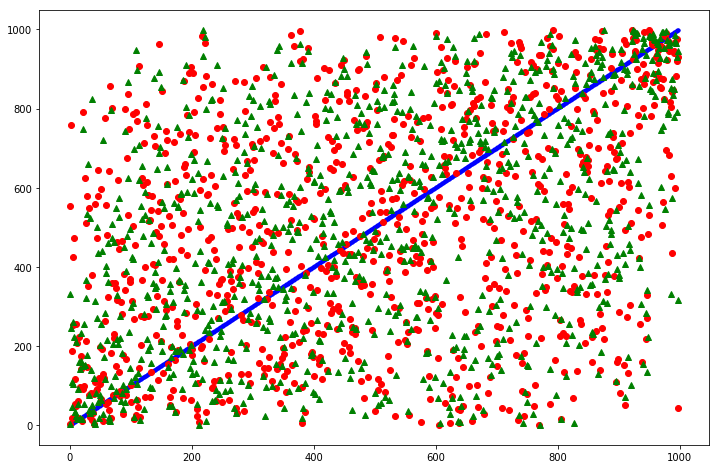

In [19]:
w2v_Slex_sorted_Slexscores = w2v_Slex_sorted.sort_values(by=['rank_simlex'], ascending=True)
w2v_Slex_sorted_Slexscores = w2v_Slex_sorted_Slexscores.set_index(pd.Index(range(0,w2v_Slex_sorted.shape[0])))
plt.figure(figsize=(12,8))
plt.plot(w2v_Slex_sorted_Slexscores.index, w2v_Slex_sorted_Slexscores['rank_simlex'], 'b.', 
         w2v_Slex_sorted_Slexscores.index, w2v_Slex_sorted_Slexscores['rank_w2v'], 'ro',
         w2v_Slex_sorted_Slexscores.index, w2v_Slex_sorted_Slexscores['rank_elmo'], 'g^')
plt.show()

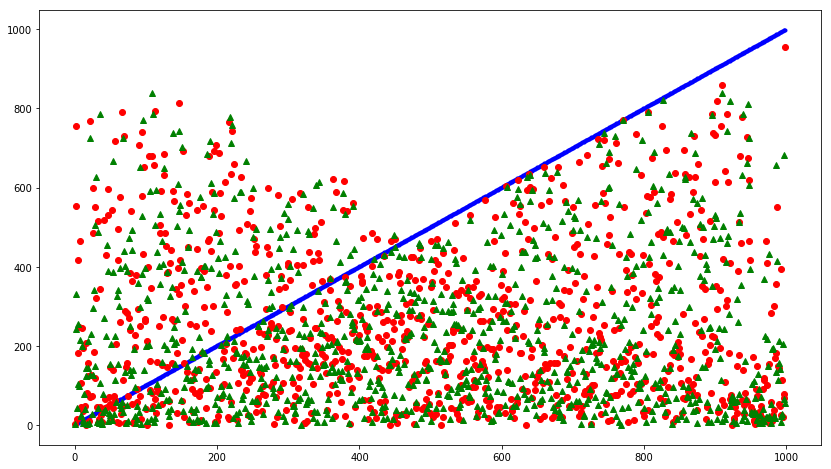

In [20]:
plt.figure(figsize=(14,8))
plt.plot(w2v_Slex_sorted.index, w2v_Slex_sorted['rank_simlex'], 'b.',
         w2v_Slex_sorted.index, w2v_Slex_sorted['rank_delta_Slex_w2v'], 'ro',
         w2v_Slex_sorted.index, w2v_Slex_sorted['rank_delta_Slex_elmo'], 'g^')
plt.show()

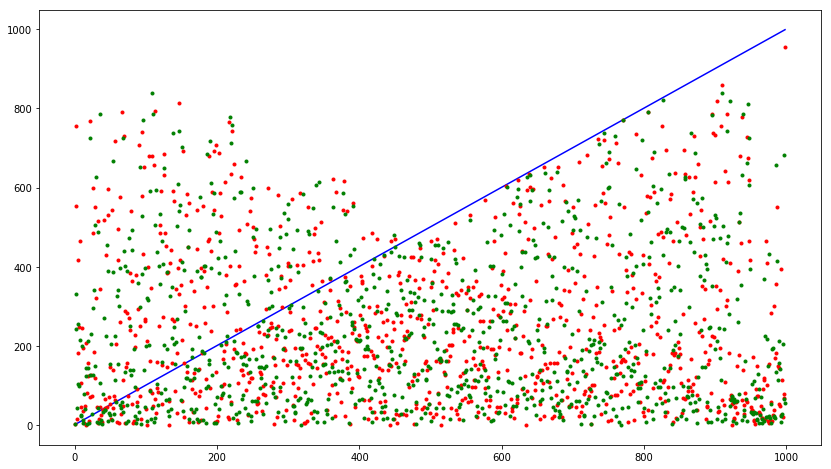

In [21]:
plt.figure(figsize=(14,8))
plt.plot(w2v_Slex_sorted.index, w2v_Slex_sorted['rank_simlex'], 'b-',
         w2v_Slex_sorted.index, w2v_Slex_sorted['rank_delta_Slex_w2v'], 'r.',
         w2v_Slex_sorted.index, w2v_Slex_sorted['rank_delta_Slex_elmo'], 'g.')
plt.show()